# 4-7. 프로젝트: 멋진 작사가 만들기

### Step 1. 데이터 다운로드
이미 실습(1) 데이터 다듬기에서 Cloud shell에 심볼릭 링크로 ~/aiffel/lyricist/data를 생성하셨다면, ~/aiffel/lyricist/data/lyrics에 데이터가 있습니다.


### Step 2. 데이터 읽어오기
glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이해요. glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장하도록 할게요!



In [1]:
import glob
import os, re
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np 

tf.config.list_physical_devices('GPU')

file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])
print("\nExample 2:", raw_corpus[11:15])

데이터 크기: 187088
Examples:
 ['[Hook]', "I've been down so long, it look like up to me", 'They look up to me']

Example 2: ["Look like you hidin' your problems", 'Really you never was solid', 'No, you can\'t "son" me', "You won't never get to run me"]


### Step 3. 데이터 정제
앞서 배운 테크닉들을 활용해 문장 생성에 적합한 모양새로 데이터를 정제하세요!

preprocess_sentence() 함수를 만든 것을 기억하시죠? 이를 활용해 데이터를 정제하도록 하겠습니다.

추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거합니다. 너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수도 있겠죠.
그래서 이번에는 문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기 를 권합니다.

In [2]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 15: break   # 일단 문장 15개만 확인해 볼 겁니다.
        
    print(sentence)

[Hook]
I've been down so long, it look like up to me
They look up to me
I got fake people showin' fake love to me
Straight up to my face, straight up to my face
I've been down so long, it look like up to me
They look up to me
I got fake people showin' fake love to me
Straight up to my face, straight up to my face [Verse 1]
Somethin' ain't right when we talkin'
Somethin' ain't right when we talkin'
Look like you hidin' your problems
Really you never was solid
No, you can't "son" me
You won't never get to run me
Just when shit look out of reach


In [3]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


짜잔, 지저분한 문장을 넣어도 예쁘게 변환해 주는 정제 함수가 완성되었습니다! 보너스로 이전 스텝에서 배운 <start> <end> 도 추가했습니다.

그러면 우리가 구축해야 할 데이터셋은 어떤 모양이 될까요?

이전 스텝에서 봤던 예를 떠올려 봅시다.
    
    
// 언어 모델의 입력 문장 :  <start> 나는 밥을 먹었다
// 언어 모델의 출력 문장 : 나는 밥을 먹었다 <end>

In [4]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> hook <end>',
 '<start> i ve been down so long , it look like up to me <end>',
 '<start> they look up to me <end>',
 '<start> i got fake people showin fake love to me <end>',
 '<start> straight up to my face , straight up to my face <end>',
 '<start> i ve been down so long , it look like up to me <end>',
 '<start> they look up to me <end>',
 '<start> i got fake people showin fake love to me <end>',
 '<start> straight up to my face , straight up to my face verse <end>',
 '<start> somethin ain t right when we talkin <end>']

### Step 4. 평가 데이터셋 분리
훈련 데이터와 평가 데이터를 분리하세요!

tokenize() 함수로 데이터를 Tensor로 변환한 후, sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리하도록 하겠습니다. 단어장의 크기는 12,000 이상 으로 설정하세요! 총 데이터의 20% 를 평가 데이터셋으로 사용해 주세요!


텐서플로우는 자연어 처리를 위한 여러 가지 모듈을 제공하는데, 우리도 그 모듈을 십분 활용할 겁니다! 아래에서 활용하게 될 tf.keras.preprocessing.text.Tokenizer 패키지는 정제된 데이터를 토큰화하고, 단어 사전(vocabulary 또는 dictionary라고 칭함)을 만들어주며, 데이터를 숫자로 변환까지 한 방에 해줍니다. 이 과정을 벡터화(vectorize) 라 하며, 숫자로 변환된 데이터를 텐서(tensor) 라고 칭합니다. 우리가 사용하는 텐서플로우로 만든 모델의 입출력 데이터는 실제로는 모두 이런 텐서로 변환되어 처리되는 것입니다.

We will create a tokenizer (vectroziation) function

In [5]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2  953    3 ...    0    0    0]
 [   2    5   91 ...    0    0    0]
 [   2   45  134 ...    0    0    0]
 ...
 [   2  211    3 ...    0    0    0]
 [   2  399    9 ...    0    0    0]
 [   2    9 1294 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f8f6dfa04d0>


생성된 텐서 데이터를 3번째 행, 10번째 열까지만 출력해 봅시다.

In [6]:
print(tensor[:3, :10])

[[  2 953   3   0   0   0   0   0   0   0]
 [  2   5  91 106  60  30 161   4  11 134]
 [  2  45 134  29  10  12   3   0   0   0]]


텐서 데이터는 모두 정수로 이루어져 있습니다. 이 숫자는 다름 아니라, tokenizer에 구축된 단어 사전의 인덱스입니다. 단어 사전이 어떻게 구축되었는지 아래와 같이 확인해 봅시다.

In [7]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [8]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2 953   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

corpus 내의 첫 번째 문장에 대해 생성된 소스와 타겟 문장을 확인해 보았습니다. 예상대로 소스는 2()에서 시작해서 3()으로 끝난 후 0()로 채워져 있습니다. 하지만 타겟은 2로 시작하지 않고 소스를 왼쪽으로 한 칸 시프트 한 형태를 가지고 있습니다.
마지막으로 우리는 데이터셋 객체를 생성할 것입니다. 그동안 우리는 model.fit(x_train, y_train, ...) 형태로 Numpy Array 데이터셋을 생성하여 model에 제공하는 형태의 학습을 많이 진행해 왔습니다. 그러나 텐서플로우를 활용할 경우 텐서로 생성된 데이터를 이용해 tf.data.Dataset객체를 생성하는 방법을 흔히 사용합니다. tf.data.Dataset객체는 텐서플로우에서 사용할 경우 데이터 입력 파이프라인을 통한 속도 개선 및 각종 편의 기능을 제공하므로 꼭 사용법을 알아 두시기를 권합니다. 우리는 이미 데이터셋을 텐서 형태로 생성해 두었으므로, tf.data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체를 생성할 것입니다.

In [9]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 346), (256, 346)), types: (tf.int32, tf.int32)>

이번 스텝에서 데이터셋을 생성하기 위해 거쳐 온 과정을 잘 기억해 두시길 바랍니다.
정규표현식을 이용한 corpus 생성 tf.keras.preprocessing.text.Tokenizer를 이용해 corpus를 텐서로 변환 tf.data.Dataset.from_tensor_slices()를 이용해 corpus 텐서를 tf.data.Dataset객체로 변환 dataset을 얻음으로써 데이터 다듬기 과정은 끝났습니다. tf.data.Dataset에서 제공하는 shuffle(), batch() 등 다양한 데이터셋 관련 기능을 손쉽게 이용할 수 있게 되었군요.


이 모든 일련의 과정을 텐서플로우에서의 데이터 전처리 라 칭합니다!

#### Step 5. 인공지능 만들기
모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하세요! (Loss는 아래 제시된 Loss 함수를 그대로 사용!)

그리고 멋진 모델이 생성한 가사 한 줄을 제출하시길 바랍니다!

#### 인공지능 학습시키기


우리가 인공지능이라고 부르는 것은 인공신경망이자 딥러닝 네트워크이자 이번 코스에선 순환신경망이기도 하고...... 너무 많은 이름이 같은 의미를 담고 있습니다. 따라서 지금부터 우리가 만들고자 하는 인공지능을 모델(model)이라고 칭하겠습니다. 실제로도 다들 모델이라고 한답니다.

우리가 만들 모델의 구조도는 아래와 같습니다.

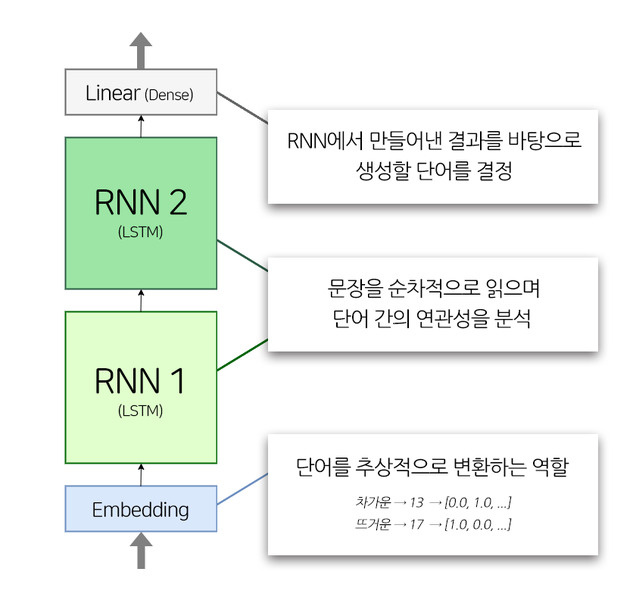

우리가 만들 모델은 tf.keras.Model을 Subclassing하는 방식으로 만들 것입니다. 위 그림에서 설명한 것처럼 우리가 만들 모델에는 1개의 Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있습니다.
각 레이어의 기능을 확실히 이해하는 것은 나중에 하고, 지금은 구조도에 설명된 정도의 간단한 이해만 가지고 갑시다.

In [10]:
# split the data into train, test, and validation set

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.25, random_state = 30)

In [11]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 32
hidden_size = 32
model = Sequential()
model.add(Bidirectional(LSTM(5)))
model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization())

model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
# why (tokenizer.num_words + 1)??

텍스트 분류 모델을 다루어 보셨다면 Embedding 레이어의 역할에 대해서는 낯설지 않을 것입니다. 우리 입력 텐서에는 단어 사전의 인덱스가 들어 있습니다. Embedding 레이어는 이 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔 줍니다. 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현(representation)으로 사용됩니다.

위 코드에서 embedding_size 는 워드 벡터의 차원수, 즉 단어가 추상적으로 표현되는 크기입니다. 만약 그 크기가 2라면 예를 들어

 - 차갑다: [0.0, 1.0]
 - 뜨겁다: [1.0, 0.0]
 - 미지근하다: [0.5, 0.5]
 

 정도의 구분이 가능하겠군요. 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만, 그만큼 충분한 데이터가 주어지지 않으면 오히려 혼란만을 야기할 수 있습니다. 이번 실습에서는 256이 적당해 보이네요.

LSTM 레이어의 hidden state 의 차원수인 hidden_size 도 같은 맥락입니다. hidden_size 는 모델에 얼마나 많은 일꾼을 둘 것인가? 로 이해해도 크게 엇나가지 않습니다. 그 일꾼들은 모두 같은 데이터를 보고 각자의 생각을 가지는데, 역시 충분한 데이터가 주어지면 올바른 결정을 내리겠지만 그렇지 않으면 배가 산으로 갈 뿐 입니다. 이번 실습에는 1024가 적당해보이는군요.  😂😂😊


우리의 model은 아직 제대로 build되지 않았습니다. model.compile()을 호출한 적도 없고, 아직 model의 입력 텐서가 무엇인지 제대로 지정해 주지도 않았기 때문입니다.
그런 경우 아래와 같이 model에 데이터를 아주 조금 태워 보는 것도 방법입니다. model의 input shape가 결정되면서 model.build()가 자동으로 호출됩니다.

==================================================================


모델의 최종 출력 텐서 shape를 유심히 보면 shape=(256, 20, 7001)임을 알 수 있습니다. 7001은 Dense 레이어의 출력 차원수입니다. 7001개의 단어 중 어느 단어의 확률이 가장 높을지를 모델링해야 하기 때문입니다.
256은 이전 스텝에서 지정한 배치 사이즈입니다. dataset.take(1)를 통해서 1개의 배치, 즉 256개의 문장 데이터를 가져온 것입니다.

그렇다면 20은 무엇을 의미할까요? 비밀은 바로 tf.keras.layers.LSTM(hidden_size, return_sequences=True)로 호출한 LSTM 레이어에서 return_sequences=True이라고 지정한 부분에 있습니다. 즉, LSTM은 자신에게 입력된 시퀀스의 길이만큼 동일한 길이의 시퀀스를 출력한다는 의미입니다. 만약 return_sequences=False였다면 LSTM 레이어는 1개의 벡터만 출력했을 것입니다.

그런데 문제는, 우리의 모델은 입력 데이터의 시퀀스 길이가 얼마인지 모른다는 점입니다. 모델을 만들면서 알려준 적도 없습니다. 그럼 20은 언제 알게된 것일까요? 네, 그렇습니다. 데이터를 입력받으면서 비로소 알게 된 것입니다. 우리 데이터셋의 max_len이 20으로 맞춰져 있었던 것입니다.

In [12]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (131811, 346)
Target Train: (131811, 346)


In [13]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 346, 7001), dtype=float32, numpy=
array([[[ 3.2916410e-05, -3.1750100e-05,  4.2681855e-05, ...,
          2.2840251e-05, -3.1111464e-05, -7.9127138e-05],
        [ 2.0502033e-05,  6.2860214e-05, -3.9418675e-05, ...,
         -7.5581469e-05, -5.4133281e-05, -9.5787735e-05],
        [ 9.5284840e-06,  1.0346358e-04, -3.4557524e-05, ...,
         -1.3018835e-04, -2.1544649e-05, -2.8564612e-04],
        ...,
        [ 1.3562407e-03, -7.7668909e-04,  2.1798576e-03, ...,
          1.3847454e-04, -2.2387346e-03,  1.2499545e-03],
        [ 1.3562407e-03, -7.7668909e-04,  2.1798576e-03, ...,
          1.3847454e-04, -2.2387346e-03,  1.2499545e-03],
        [ 1.3562407e-03, -7.7668909e-04,  2.1798576e-03, ...,
          1.3847454e-04, -2.2387346e-03,  1.2499545e-03]],

       [[ 3.2916410e-05, -3.1750100e-05,  4.2681855e-05, ...,
          2.2840251e-05, -3.1111464e-05, -7.9127138e-05],
        [ 1.4420437e-05, -1.3471626e-05, -1.2865060e-05, ...,
         -4.9408238e-05, 

이제 드디어 model.summary()를 호출할 수 있게 되었습니다. 그런데 호출해 보니 그동안 많이 보았던 것과는 다른 점이 있습니다. 우리가 궁금했던 Output Shape를 정확하게 알려주지 않습니다. 바로 위에서 설명한 이유 때문입니다. 우리의 모델은 입력 시퀀스의 길이를 모르기 때문에 Output Shape를 특정할 수 없는 것입니다.

하지만 모델의 파라미터 사이즈는 측정됩니다. 대략 22million 정도 되는군요. 참고로 서두에 소개했던 GPT-2의 파라미터 사이즈는, 1.5billion입니다. 우리 모델의 100배까지는 안되더라도 수십배가 넘는군요. 놀라지 마세요. GPT-3의 파라미터 사이즈는 GPT-2의 100배니까요.

In [14]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  224032    
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8320      
_________________________________________________________________
lstm_2 (LSTM)                multiple                  8320      
_________________________________________________________________
dense (Dense)                multiple                  231033    
Total params: 471,705
Trainable params: 471,705
Non-trainable params: 0
_________________________________________________________________


이제 모델이 학습할 준비가 완료되었습니다. 아래 코드를 실행해 모델을 학습시켜보세요!

학습엔 15분 정도 소요됩니다(GPU 환경 기준). 간단한 스트레칭과 커피 한 잔을 만들어 오기에 적당한 시간이죠.
혹시라도 학습에 지나치게 많은 시간이 소요된다면 tf.test.is_gpu_available() 소스를 실행해 텐서플로우가 GPU를 잘 사용하고 있는지 확인하시길 바랍니다!

In [15]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

tf.test.is_gpu_available()

#add callbacks for the learning rate improvement
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

model.compile(loss=loss, optimizer=optimizer)

model.fit(enc_train, dec_train, epochs=10, validation_data=(enc_val, dec_val), callbacks=my_callbacks)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Epoch 1/10
4120/4120 [==============================] - 657s 159ms/step - loss: 0.8680 - val_loss: 0.1464
Epoch 2/10
4120/4120 [==============================] - 623s 151ms/step - loss: 0.1445 - val_loss: 0.1381
Epoch 3/10
4120/4120 [==============================] - 622s 151ms/step - loss: 0.1362 - val_loss: 0.1336
Epoch 4/10
4120/4120 [==============================] - 621s 151ms/step - loss: 0.1321 - val_loss: 0.1308
Epoch 5/10
4120/4120 [==============================] - 622s 151ms/step - loss: 0.1288 - val_loss: 0.1289
Epoch 6/10
4120/4120 [==============================] - 637s 155ms/step - loss: 0.1263 - val_loss: 0.1275
Epoch 7/10
4120/4120 [==============================] - 627s 152ms/step - loss: 0.1249 - val_loss: 0.1263
Epoch 8/10
4120/4120 [==============================] - 621s 151ms/step - loss: 0.1233 - val_loss: 0.1254
Epoch 9/10
4120/4120 [==============================] - 621s 151ms/step

Loss는 모델이 오답을 만들고 있는 정도라고 생각하셔도 좋습니다(그렇다고 Loss가 1일 때 99%를 맞추고 있다는 의미는 아닙니다). 오답률이 감소하고 있으니 학습이 잘 진행되고 있다 고 해석할 수 있죠!

학습이 완료되었다면 이제 모델을 평가해 봅시다.


In [30]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다.
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]  # 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됨

        # 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여줌
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated


만약 결과가 다르다면 천천히 과정을 다시 살펴 동일한 결과를 얻도록 하세요! 만약 학습 데이터 개수가 124960보다 크다면 위 Step 3.의 데이터 정제 과정을 다시 한번 검토해 보시기를 권합니다.

데이터가 커서 훈련하는 데 시간이 제법 걸릴 겁니다. 여유를 가지고 작업하시면 좋아요 :)

In [31]:
test_sentence = [
    'i love',
    'That you were',
    'I got',
    'I keep waiting',
    "I've started talking",
    "I'm right here for you",
    'Do you wanna build',
    'Please, I don’t want to',
    'Just go to the',
    'Why should I',
    "It's a good day"]

for sentence in test_sentence:
    input_sentence = f'<start> {sentence}'
    
    new_sentence1 = generate_text(model, tokenizer, init_sentence=input_sentence, max_len=20)
    
    print('Input sentence : ', sentence)
    print('   LSTM -> ', new_sentence1[7:-7])
    print('*'*40)

Input sentence :  i love
   LSTM ->   i love you , i m a <unk>
****************************************
Input sentence :  That you were
   LSTM ->   that you were the one
****************************************
Input sentence :  I got
   LSTM ->   i got a <unk> , i m a <unk>
****************************************
Input sentence :  I keep waiting
   LSTM ->   i keep waiting for the way you re the one
****************************************
Input sentence :  I've started talking
   LSTM ->   <unk> started talking
****************************************
Input sentence :  I'm right here for you
   LSTM ->   <unk> right here for you
****************************************
Input sentence :  Do you wanna build
   LSTM ->   do you wanna build me
****************************************
Input sentence :  Please, I don’t want to
   LSTM ->   <unk> i <unk> want to get it
****************************************
Input sentence :  Just go to the
   LSTM ->   just go to the <unk>
*************

#### Q4. 모델이 생성한 가사 한 줄을 제출하세요.

Input sentence :  Why should I
   
   
   

LSTM ->   why should i go to get it
****************************************

#### 학습 결과 시각화

TypeError: 'TextGenerator' object is not subscriptable

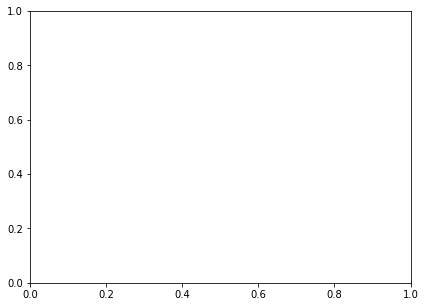